# Parameter selection example - PICO

In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from parameter_selection_toolbox import *

# Settings

In [2]:
# Directories
figure_dir = 'figures'
data_path="/media/NAS2/ISMIP7/"
ensemble_path="/media/NAS2/pism_out/"

# Constants
yearlen = 365.14*24*60*60 # seconds per year
ice_density = 918 # kg/m3
reso=8000 # m model resolution used for melt parameterisation [m]


# parameterisation ensemble table 
p1_name = 'ocean.pico.overturning_coefficent'
p2_name = 'ocean.pico.heat_exchange_coefficent'

pism_present_day_ensemble = "pism_11_ismip7_picotest_zhou_initmip8km"
ensemble_table = pd.read_csv('./'+pism_present_day_ensemble+'.txt',
                                 sep=r'\s+',index_col=0)
#ensemble_table

# Supporting data

In [3]:
# basin file to aggregate and compare data, note that this has been pre-processed for pism input, please see https://github.com/pism/pism-ais.git or ask me
pico_climatology = xr.load_dataset(os.path.join(data_path,"climatologies_on_ismip_grid","zhou_annual_30_sep","zhou_ismip8km_readyForPISM_means.nc"))
baseline_temp_per_basin = pico_climatology['theta_ocean'].groupby(pico_climatology['basins']).mean()

number_of_basins = int(pico_climatology['basins'].max().values)

# load pico boxes, for applying constraints on pico parameters and masking melt in ice shelves
boxes = xr.load_dataset(os.path.join(ensemble_path,"pism_11_ismip7_picotest_zhou_initmip8km_"+ensemble_table.index[0],"extras.nc"),
                        decode_timedelta=True, drop_variables=['pico_T_star', 'shelfbtemp', 
                                                               'pico_basal_melt_rate', 'pico_contshelf_mask',
                                                               'pico_ice_rise_mask', 'pico_overturning',
                                                               'pico_salinity', 'pico_salinity_box0',
                                                               'pico_shelf_mask', 'pico_temperature', 
                                                               'pico_temperature_box0'] )['pico_box_mask'].isel(time=0)

In [4]:
#PaoloDataImbie = pd.read_csv('../Melt_Paolo_Err_Adusumilli_imbie2.csv', index_col=0)
PaoloDataPICO = pd.read_csv('PaoloData_pico.csv', index_col=0)

# Find optimal deltaT for PICO
Note that this uses the PICO basins, which differ from the imbie2 basins as used in ismip7

In [5]:

model_runs = [] 
p1s = []
p2s = []

for i,ehash in enumerate(ensemble_table.index):
    
    p1 = ensemble_table.loc[ehash, p1_name]
    p2 = ensemble_table.loc[ehash, p2_name]
    p1s.append(p1)
    p2s.append(p2) 
    print(i, 'p1=', p1, ' p2=', p2)

    output_path = os.path.join(ensemble_path, pism_present_day_ensemble+"_"+ehash)

    try:
        print('Loading dataset')
        result_ds = xr.load_dataset(output_path+"/optimised.nc")
    except:
        ds = xr.open_dataset(os.path.join(output_path,'extras.nc'),decode_timedelta=True, drop_variables=['pico_T_star', 'shelfbtemp', 
                                                                                                    'pico_box_mask', 'pico_contshelf_mask',
                                                                                                   'pico_ice_rise_mask', 'pico_overturning',
                                                                                                   'pico_salinity', 'pico_salinity_box0',
                                                                                                   'pico_shelf_mask', 'pico_temperature', 
                                                                                                  ],)
        ds = ds.rename({'pico_basal_melt_rate':'melt_rate'})
        # convert time to deltaT, this is a trick to avoid running an ensemble over deltaT
        deltaT_coords = np.round(ds['pico_temperature_box0'].groupby(pico_climatology['basins']).mean().sel(basins=14) - 273.15 - baseline_temp_per_basin.sel(basins=14), 2)
        new_ds = xr.Dataset( data_vars=dict(melt_rate=(["deltaT","y", "x"], ds["melt_rate"].where(boxes>0,np.nan).values)), 
                                 coords=dict(x=(["x"], ds['x'].values), y=(["y"], ds['y'].values), deltaT=(["deltaT"],deltaT_coords.values) ))
        ds.close()
    
        
        outname = os.path.join(ensemble_path,pism_present_day_ensemble+'_'+ehash, "optimised.nc")
        result_ds = select_optimal_deltaT(new_ds, pico_climatology['basins'], boxes ,PaoloDataPICO, 'pico', outname, reso, ice_density)

    try:
        result_ds = result_ds.rename({'pico_basal_melt_rate':'melt_rate'})
    except:
        print(' No need to rename')
    result_ds = result_ds.assign_coords(ehash=ehash)
    model_runs.append(result_ds)

0 p1= 100000.0  p2= 1e-06
Loading dataset
Identifying optimal delta T for each basin...
 No need to rename
1 p1= 100000.0  p2= 2.5e-06
Loading dataset
Identifying optimal delta T for each basin...
 No need to rename
2 p1= 100000.0  p2= 5e-06
Loading dataset
Identifying optimal delta T for each basin...
 No need to rename
3 p1= 100000.0  p2= 7.5e-06
Loading dataset
Identifying optimal delta T for each basin...
 No need to rename
4 p1= 100000.0  p2= 1e-05
Loading dataset
Identifying optimal delta T for each basin...
 No need to rename
5 p1= 100000.0  p2= 2.5e-05
Loading dataset
Identifying optimal delta T for each basin...
 No need to rename
6 p1= 100000.0  p2= 5e-05
Loading dataset
Identifying optimal delta T for each basin...
 No need to rename
7 p1= 100000.0  p2= 7.5e-05
Loading dataset
Identifying optimal delta T for each basin...
 No need to rename
8 p1= 100000.0  p2= 0.0001
Loading dataset
Identifying optimal delta T for each basin...
 No need to rename
9 p1= 100000.0  p2= 0.000125

In [7]:
print('Combining datasets')
pd_ensemble_sel = xr.concat(model_runs, dim='ehash', coords='minimal')

# change ehash to C and gammaT dimensions
pd_ensemble_sel = pd_ensemble_sel.assign_coords({ 
    'p1': ('ehash', p1s),
    'p2': ('ehash', p2s)
}).set_index(ehash=['p1', 'p2']).unstack('ehash')


pd_ensemble_sel.encoding = {}
pd_ensemble_sel.to_netcdf('Ensemble_pd_optimaldeltaT.nc')

Combining datasets


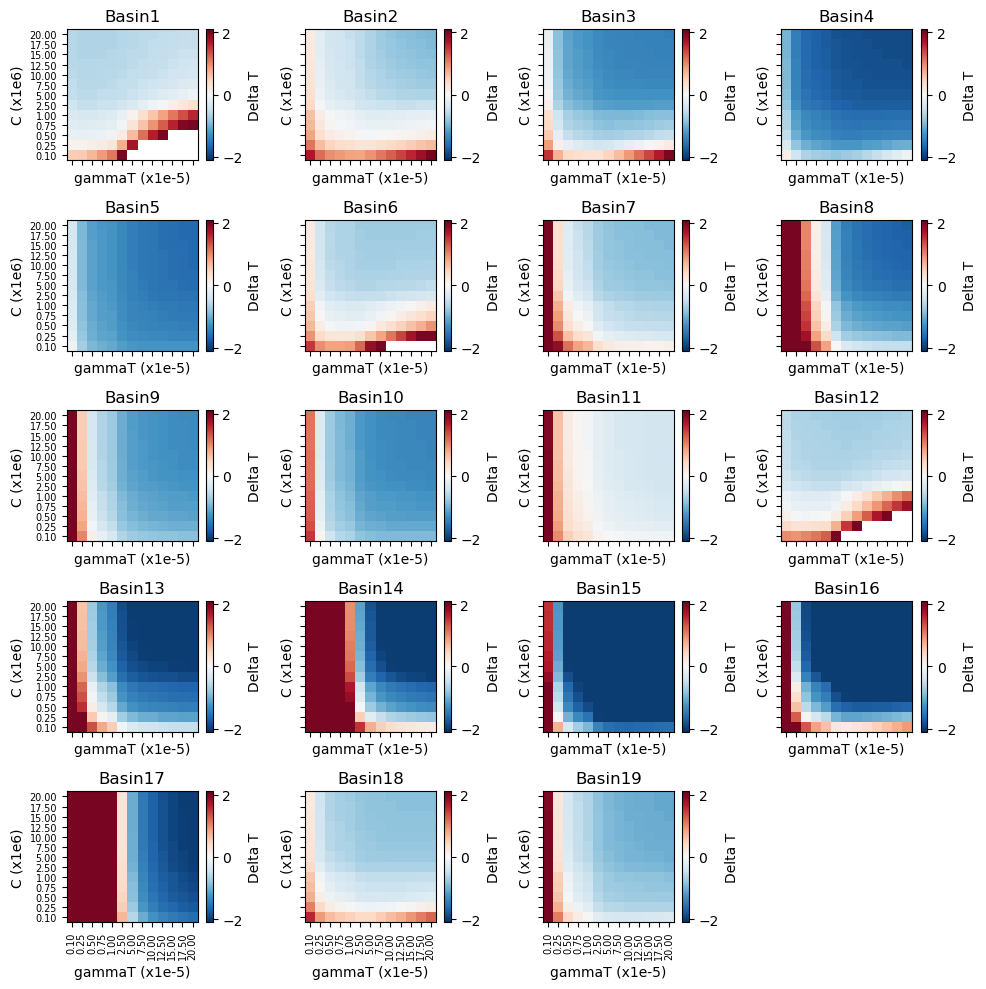

In [8]:
# Plot residuals for each basin, note that white area are where PICO physical constraints all fail
fig,axes = plt.subplots(5,4, sharex=True, sharey=True, figsize=(10, 10))

for i in range(number_of_basins):
    ax = axes.flatten()[i]

    im = ax.imshow(pd_ensemble_sel['optimal_deltaT_per_basin'].sel(basin=i+1).values,cmap='RdBu_r', vmin=-2.1, vmax=2.1, origin='lower')
    plt.colorbar(im, label='Delta T')
    p1_values = pd_ensemble_sel['p1'].values/1e6
    p2_values = pd_ensemble_sel['p2'].values*1e5
    
    ax.set_yticks(np.arange(len(p1_values)))
    ax.set_yticklabels([f'{v:.2f}' for v in p1_values], fontsize=7)#, rotation=45)
    
    ax.set_xticks(np.arange(len(p2_values)))
    ax.set_xticklabels([f'{v:.2f}' for v in p2_values], rotation=90, fontsize=7)

    ax.set_title('Basin'+str( i+1) ) 
    ax.set_xlabel('gammaT (x1e-5)')
    ax.set_ylabel('C (x1e6)')
    
#fig.autofmt_xdate()
fig.tight_layout()
axes.flat[-1].set_visible(False)
plt.savefig(os.path.join(figure_dir,'PICO_Ensemble_optimalDeltaT_deltaTPerBasin.png'))


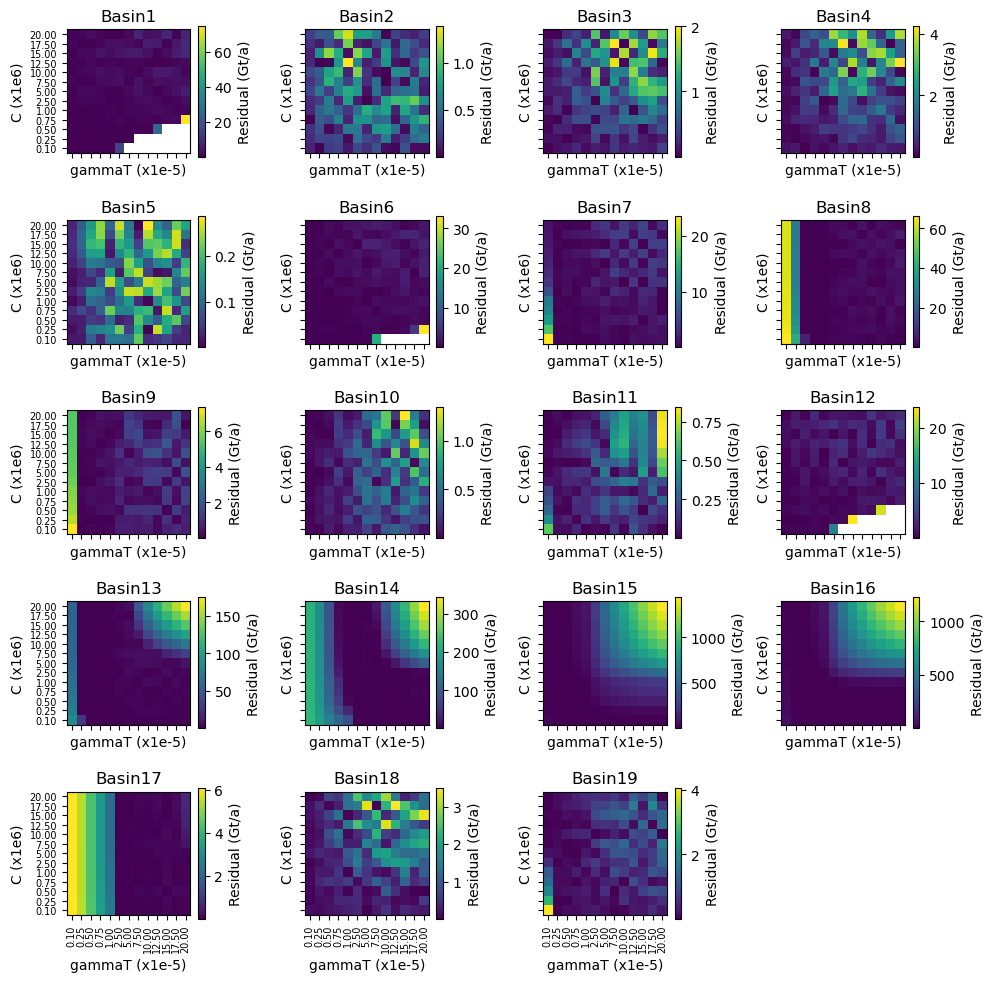

In [9]:
# Plot residuals for each PICO basin, note that white area are where PICO physical constraints all fail
fig,axes = plt.subplots(5,4, sharex=True, sharey=True, figsize=(10, 10))


for i in range(number_of_basins):
    ax = axes.flatten()[i]

    im = ax.imshow(pd_ensemble_sel['residual_per_basin'].sel(basin=i+1).values, origin='lower')
    plt.colorbar(im, label='Residual (Gt/a)')
    p1_values = pd_ensemble_sel['p1'].values/1e6
    p2_values = pd_ensemble_sel['p2'].values*1e5
    
    ax.set_yticks(np.arange(len(p1_values)))
    ax.set_yticklabels([f'{v:.2f}' for v in p1_values], fontsize=7)#, rotation=45)
    
    ax.set_xticks(np.arange(len(p2_values)))
    ax.set_xticklabels([f'{v:.2f}' for v in p2_values], rotation=90, fontsize=7)

    ax.set_title('Basin'+str( i+1) ) 
    ax.set_xlabel('gammaT (x1e-5)')
    ax.set_ylabel('C (x1e6)')
    
#fig.autofmt_xdate()
fig.tight_layout()
axes.flat[-1].set_visible(False)

plt.savefig(os.path.join(figure_dir,'PICO_Ensemble_optimalDeltaT_ResidualsPerBasin.png'))

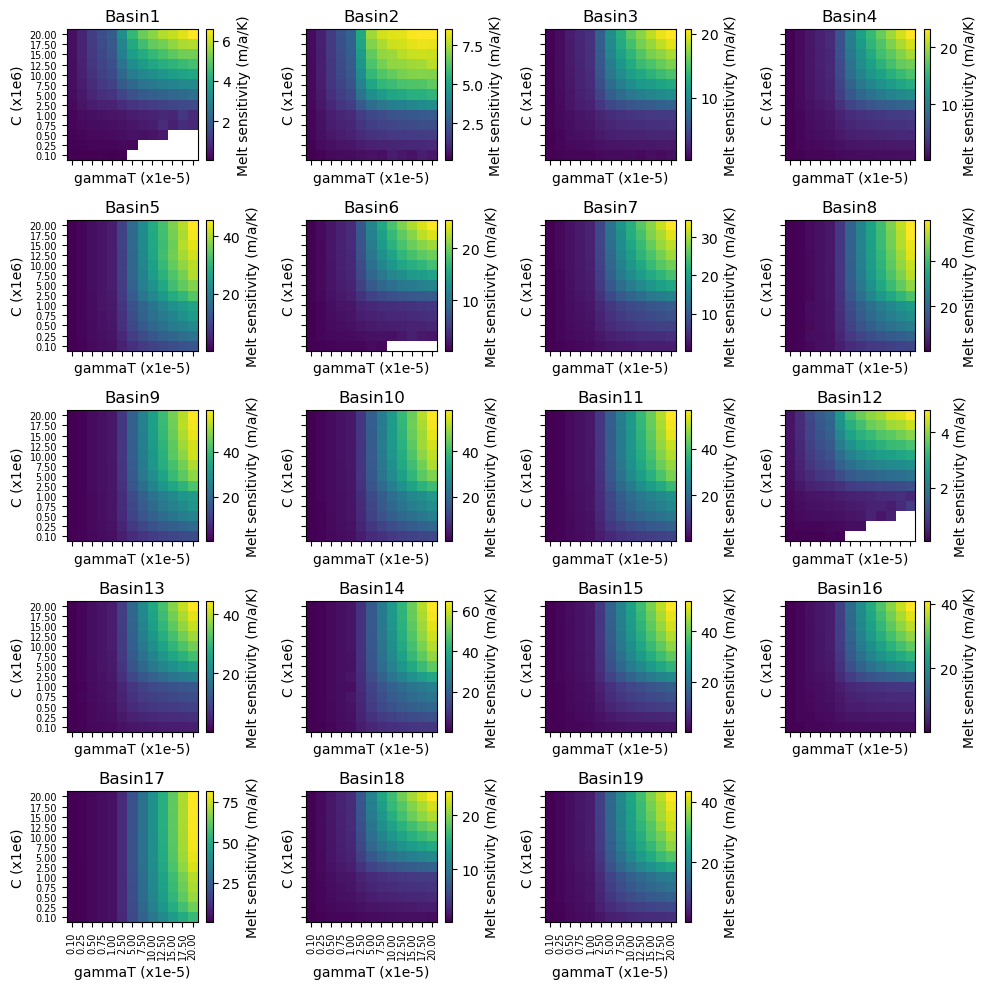

In [10]:
# Plot rough sensitivity estimates (note that they are not calculated over equal intervals)

fig,axes = plt.subplots(5,4, sharex=True, sharey=True, figsize=(10, 10))

for i in range(number_of_basins):
    ax = axes.flatten()[i]

    im = ax.imshow(pd_ensemble_sel['sensitivity_per_basin'].sel(basin=i+1).values, origin='lower')
    plt.colorbar(im, label='Melt sensitivity (m/a/K)')
    p1_values = pd_ensemble_sel['p1'].values/1e6
    p2_values = pd_ensemble_sel['p2'].values*1e5
    
    ax.set_yticks(np.arange(len(p1_values)))
    ax.set_yticklabels([f'{v:.2f}' for v in p1_values], fontsize=7)#, rotation=45)
    
    ax.set_xticks(np.arange(len(p2_values)))
    ax.set_xticklabels([f'{v:.2f}' for v in p2_values], rotation=90, fontsize=7)

    ax.set_title('Basin'+str( i+1) ) 
    ax.set_xlabel('gammaT (x1e-5)')
    ax.set_ylabel('C (x1e6)')
    
#fig.autofmt_xdate()
fig.tight_layout()
axes.flat[-1].set_visible(False)
plt.savefig(os.path.join(figure_dir,'PICO_Ensemble_optimalDeltaT_RoughSensitivityEstimatesPerBasin.png'))

# Apply optimal deltaT to ocean modelling datasets

In [11]:
# if you want to skip the lengthy calculation of pd_ensemble_sel
pd_ensemble_sel = xr.load_dataset('Ensemble_pd_optimaldeltaT.nc', drop_variables=['timestamp'])

In [12]:
# iterate over all subensembles

opt_ensemble = xr.load_dataset('Ensemble_pd_optimaldeltaT.nc')
basins = pico_climatology['basins']

ensembles = ['pism_11_ismip7_picotest_Mathiot_cold_initmip8km', 'pism_11_ismip7_picotest_Mathiot_warm_initmip8km']


# get deltaT's relative to present-day climatology
model_file = os.path.join("/media/NAS2/pism_out/",pism_present_day_ensemble+"_"+'ee8f65fd')
ds = xr.open_dataset(model_file+'/extras.nc',decode_timedelta=True, drop_variables=['pico_T_star', 'shelfbtemp', 
                                                                                                    'pico_box_mask', 'pico_contshelf_mask',
                                                                                                   'pico_ice_rise_mask', 'pico_overturning',
                                                                                                   'pico_salinity', 'pico_salinity_box0',
                                                                                                   'pico_shelf_mask', 'pico_temperature', 
                                                                                                  ],
                                    )
deltaT_coords = np.round(ds['pico_temperature_box0'].groupby(pico_climatology['basins']).mean().sel(basins=14) - 273.15 - baseline_temp_per_basin.sel(basins=14), 2)
ds.close()

for ensemble in ensembles:
    print(ensemble)
    for i,ehash in enumerate(ensemble_table.index):
        p1 = ensemble_table.loc[ehash, p1_name]
        p2 = ensemble_table.loc[ehash, p2_name]
        print(ehash, i, 'p1=', p1, ' p2=', p2)

        # pre-process time to deltaT dimension
        pico_output_file = os.path.join(ensemble_path, ensemble+"_"+ehash)
        ds = xr.open_dataset(pico_output_file+'/extras.nc',decode_timedelta=True, drop_variables=['pico_T_star', 'shelfbtemp', 
                                                                                                    'pico_box_mask', 'pico_contshelf_mask',
                                                                                                   'pico_ice_rise_mask', 'pico_overturning',
                                                                                                   'pico_salinity', 'pico_salinity_box0',
                                                                                                   'pico_shelf_mask', 'pico_temperature', 
                                                                                                  ], )
        ds = ds.rename({'pico_basal_melt_rate':'melt_rate'})
        new_ds = xr.Dataset( data_vars=dict(melt_rate=(["deltaT","y", "x"], ds["melt_rate"].where(boxes>0,np.nan).values)), coords=dict( 
                                 x=(["x"], ds['x'].values), y=(["y"], ds['y'].values), deltaT=(["deltaT"],deltaT_coords.values) ))
        ds.close()
    
        
        outname = os.path.join(ensemble_path,ensemble+"_"+ehash,"optimised.nc")
        
        select_subensemble_using_optimal_deltaT(new_ds, basins, opt_ensemble, outname, p1, p2)
        new_ds.close()
      

pism_11_ismip7_picotest_Mathiot_cold_initmip8km
ee8f65fd 0 p1= 100000.0  p2= 1e-06
Select sub-ensemble...
0f40f1ef 1 p1= 100000.0  p2= 2.5e-06
Select sub-ensemble...
857e9fd2 2 p1= 100000.0  p2= 5e-06
Select sub-ensemble...
83f3e03d 3 p1= 100000.0  p2= 7.5e-06
Select sub-ensemble...
e89d93e7 4 p1= 100000.0  p2= 1e-05
Select sub-ensemble...
52bdd9bc 5 p1= 100000.0  p2= 2.5e-05
Select sub-ensemble...
19432721 6 p1= 100000.0  p2= 5e-05
Select sub-ensemble...
c1ad85bb 7 p1= 100000.0  p2= 7.5e-05
Select sub-ensemble...
81e0fcf4 8 p1= 100000.0  p2= 0.0001
Select sub-ensemble...
56fcf892 9 p1= 100000.0  p2= 0.000125
Select sub-ensemble...
29728425 10 p1= 100000.0  p2= 0.00015
Select sub-ensemble...
3dce6516 11 p1= 100000.0  p2= 0.000175
Select sub-ensemble...
42385f81 12 p1= 100000.0  p2= 0.0002
Select sub-ensemble...
4bbc33e4 13 p1= 250000.0  p2= 1e-06
Select sub-ensemble...
da5e8b91 14 p1= 250000.0  p2= 2.5e-06
Select sub-ensemble...
9217ed61 15 p1= 250000.0  p2= 5e-06
Select sub-ensemble..

# Combine datasets

In [13]:
pism_present_day_ensemble = "pism_11_ismip7_picotest_zhou_initmip8km"
pism_mathiot_cold_ensemble = "pism_11_ismip7_picotest_Mathiot_cold_initmip8km"
pism_mathiot_warm_ensemble = "pism_11_ismip7_picotest_Mathiot_warm_initmip8km"


In [14]:
# Create ensemble
pd_ensemble = load_melt_rates_into_dataset(pism_present_day_ensemble, ensemble_table, ensemble_path, p1_name, p2_name)
# Save pd_ensemble
pd_ensemble.encoding = {}
pd_ensemble.to_netcdf('Ensemble_'+pism_present_day_ensemble+'_optimaldeltaT.nc')


Loading pism_11_ismip7_picotest_zhou_initmip8km into one dataset...
0 : loading dataset for parameter 1= 100000.0  parameter 2= 1e-06
1 : loading dataset for parameter 1= 100000.0  parameter 2= 2.5e-06
2 : loading dataset for parameter 1= 100000.0  parameter 2= 5e-06
3 : loading dataset for parameter 1= 100000.0  parameter 2= 7.5e-06
4 : loading dataset for parameter 1= 100000.0  parameter 2= 1e-05
5 : loading dataset for parameter 1= 100000.0  parameter 2= 2.5e-05
6 : loading dataset for parameter 1= 100000.0  parameter 2= 5e-05
7 : loading dataset for parameter 1= 100000.0  parameter 2= 7.5e-05
8 : loading dataset for parameter 1= 100000.0  parameter 2= 0.0001
9 : loading dataset for parameter 1= 100000.0  parameter 2= 0.000125
10 : loading dataset for parameter 1= 100000.0  parameter 2= 0.00015
11 : loading dataset for parameter 1= 100000.0  parameter 2= 0.000175
12 : loading dataset for parameter 1= 100000.0  parameter 2= 0.0002
13 : loading dataset for parameter 1= 250000.0  param

In [15]:
mathiot_cold_ensemble = load_melt_rates_into_dataset(pism_mathiot_cold_ensemble, ensemble_table, ensemble_path, p1_name, p2_name)
# Save
mathiot_cold_ensemble.encoding = {}
mathiot_cold_ensemble.to_netcdf('Ensemble_'+pism_mathiot_cold_ensemble+'_optimaldeltaT.nc')

Loading pism_11_ismip7_picotest_Mathiot_cold_initmip8km into one dataset...
0 : loading dataset for parameter 1= 100000.0  parameter 2= 1e-06
1 : loading dataset for parameter 1= 100000.0  parameter 2= 2.5e-06
2 : loading dataset for parameter 1= 100000.0  parameter 2= 5e-06
3 : loading dataset for parameter 1= 100000.0  parameter 2= 7.5e-06
4 : loading dataset for parameter 1= 100000.0  parameter 2= 1e-05
5 : loading dataset for parameter 1= 100000.0  parameter 2= 2.5e-05
6 : loading dataset for parameter 1= 100000.0  parameter 2= 5e-05
7 : loading dataset for parameter 1= 100000.0  parameter 2= 7.5e-05
8 : loading dataset for parameter 1= 100000.0  parameter 2= 0.0001
9 : loading dataset for parameter 1= 100000.0  parameter 2= 0.000125
10 : loading dataset for parameter 1= 100000.0  parameter 2= 0.00015
11 : loading dataset for parameter 1= 100000.0  parameter 2= 0.000175
12 : loading dataset for parameter 1= 100000.0  parameter 2= 0.0002
13 : loading dataset for parameter 1= 250000.

In [16]:
mathiot_warm_ensemble = load_melt_rates_into_dataset(pism_mathiot_warm_ensemble, ensemble_table, ensemble_path, p1_name, p2_name)
# Save
mathiot_warm_ensemble.encoding = {}
mathiot_warm_ensemble.to_netcdf('Ensemble_'+pism_mathiot_warm_ensemble+'_optimaldeltaT.nc')

Loading pism_11_ismip7_picotest_Mathiot_warm_initmip8km into one dataset...
0 : loading dataset for parameter 1= 100000.0  parameter 2= 1e-06
1 : loading dataset for parameter 1= 100000.0  parameter 2= 2.5e-06
2 : loading dataset for parameter 1= 100000.0  parameter 2= 5e-06
3 : loading dataset for parameter 1= 100000.0  parameter 2= 7.5e-06
4 : loading dataset for parameter 1= 100000.0  parameter 2= 1e-05
5 : loading dataset for parameter 1= 100000.0  parameter 2= 2.5e-05
6 : loading dataset for parameter 1= 100000.0  parameter 2= 5e-05
7 : loading dataset for parameter 1= 100000.0  parameter 2= 7.5e-05
8 : loading dataset for parameter 1= 100000.0  parameter 2= 0.0001
9 : loading dataset for parameter 1= 100000.0  parameter 2= 0.000125
10 : loading dataset for parameter 1= 100000.0  parameter 2= 0.00015
11 : loading dataset for parameter 1= 100000.0  parameter 2= 0.000175
12 : loading dataset for parameter 1= 100000.0  parameter 2= 0.0002
13 : loading dataset for parameter 1= 250000.

# Optimisation - load data

In [5]:
pism_present_day_ensemble = "pism_11_ismip7_picotest_zhou_initmip8km"
pism_mathiot_cold_ensemble = "pism_11_ismip7_picotest_Mathiot_cold_initmip8km"
pism_mathiot_warm_ensemble = "pism_11_ismip7_picotest_Mathiot_warm_initmip8km"

In [6]:
# Supporting Data

# Load imbie2 basins as used on ISMIP
basins = xr.load_dataset("basinNumbers_8km.nc")
basins = basins.rename({'basinNumber':'basins'})
nBasins = int(basins.basins.max())

# present-day melting, melt rates from Paolo et al., 2023, error estimates combined from Paolo and Adusumilli et al., 2020
melt_obs = xr.load_dataset('melt_paolo_err_adusumilli_ismip8km.nc') # Field
MeltDataImbie = pd.read_csv('Paolo23/Melt_Paolo_Err_Adusumilli_imbie2.csv', index_col=0) # Aggregated per imbier basin

# Buttressing Flux Response Numbers, remapped to 8km 
bfrn = xr.load_dataset("BFRN_ismip8km.nc")
nBins = 10

In [7]:
# Load ensembles
pd_ensemble = xr.load_dataset('Ensemble_'+pism_present_day_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
mathiot_cold_ensemble = xr.load_dataset('Ensemble_'+pism_mathiot_cold_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
mathiot_warm_ensemble = xr.load_dataset('Ensemble_'+pism_mathiot_warm_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])

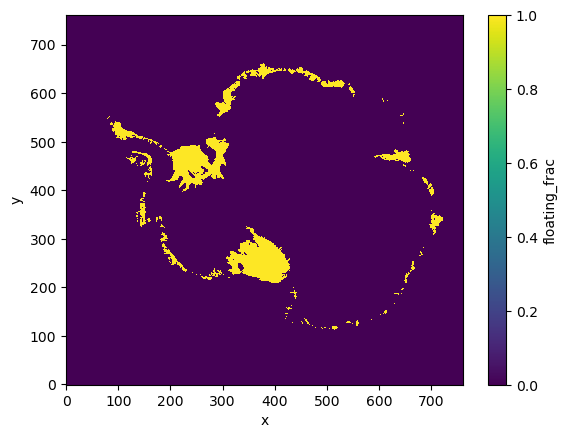

In [9]:
bed = xr.load_dataset("/media/NAS2/ISMIP7/share_with_modellers/topography/bedmap3_ismip_8km.nc")

mask = bed.floating_frac>0.5
mask.plot()

# Optimise and Visualise results

In [30]:
sample_size=10000
min_p1, min_p2, min_coords = calculate_objective_function('all',sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

Sampling, this might take a moment...


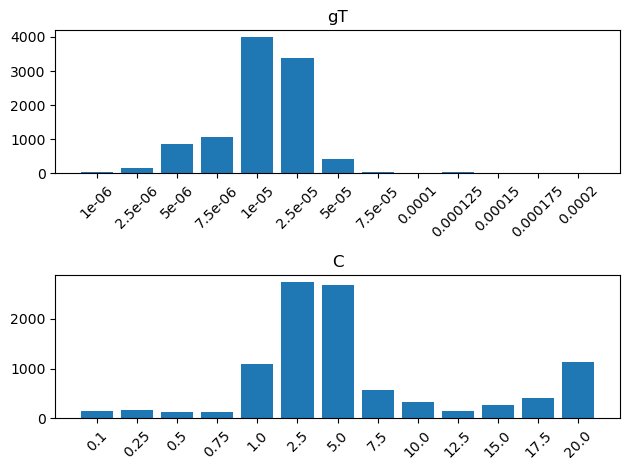

In [31]:
fig,axes = plt.subplots(2,1, sharex=False, sharey=False)
ax = axes.flatten()[0]

bin_edges = np.array( [0.01e-5,0.15e-5,0.3e-5,0.6e-5,0.8e-5,1.1e-5,3e-5,6e-5,8e-5,11e-5,13e-5,16e-5,18e-5,21e-5])
counts, _ = np.histogram(np.array(min_p2), bins= bin_edges)
positions = np.arange(len(counts))
ax.bar(positions, counts, width=0.8)
labels = [0.1e-5,0.25e-5,0.5e-5,0.75e-5,1e-5,2.5e-5,5e-5,7.5e-5,10e-5,12.5e-5,15e-5,17.5e-5,20e-5]# [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('gT')

ax = axes.flatten()[1]
bin_edges = np.array( [0.001e6,0.2e6, 0.3e6, 0.6e6, 0.8e6 ,1.1e6 ,3e6, 6e6, 8e6, 11e6, 13e6, 16e6, 18e6, 21e6]) /1e6
counts, _ = np.histogram(np.array(min_p1)/1e6, bins= bin_edges)
positions = np.arange(len(counts))
ax.bar(positions, counts, width=0.8)
labels = np.array([0.1e6, 0.25e6, 0.5e6, 0.75e6 ,1.0e6 ,2.5e6, 5.0e6, 7.5e6, 10.0e6, 12.5e6, 15e6, 17.5e6, 20e6])/1e6  #[f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('C')
plt.tight_layout()

#plt.savefig(os.path.join(figure_dir,pism_presentday_ensemble+'_Hists_Sample'+str(sample_size)+'.png'))

<Figure size 640x480 with 0 Axes>

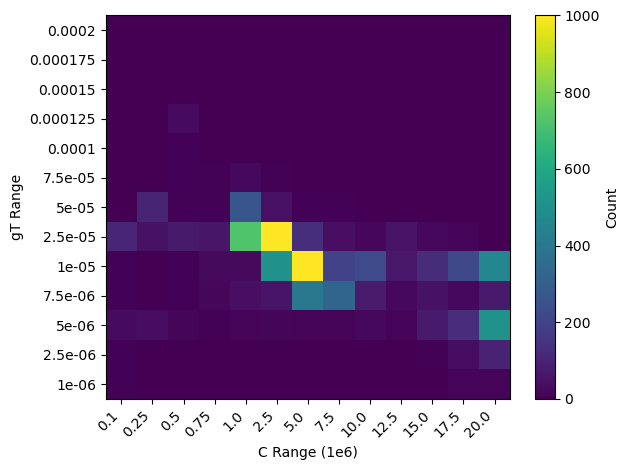

In [35]:
fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes

y_edges = np.array( [0.01e-5,0.15e-5,0.3e-5,0.6e-5,0.8e-5,1.1e-5,3e-5,6e-5,8e-5,11e-5,13e-5,16e-5,18e-5,21e-5])
x_edges = np.array( [0.001e6,0.2e6, 0.3e6, 0.6e6, 0.8e6 ,1.1e6 ,3e6, 6e6, 8e6, 11e6, 13e6, 16e6, 18e6, 21e6]) /1e6
counts, _, _ = np.histogram2d(np.array(min_p1)/1e6, min_p2, bins=[x_edges, y_edges])
plt.clf()

fig, ax = plt.subplots()

im = ax.pcolormesh(np.arange(len(x_edges)), np.arange(len(y_edges)), 
                    counts.T, cmap='viridis', shading='auto', vmin=0 , vmax=1000
                  )

x_labels = np.array([0.1e6, 0.25e6, 0.5e6, 0.75e6 ,1.0e6 ,2.5e6, 5.0e6, 7.5e6, 10.0e6, 12.5e6, 15e6, 17.5e6, 20e6]) /1e6
y_labels = [0.1e-5,0.25e-5,0.5e-5,0.75e-5,1e-5,2.5e-5,5e-5,7.5e-5,10e-5,12.5e-5,15e-5,17.5e-5,20e-5]

# Set tick positions and labels
ax.set_xticks(np.arange(len(x_labels))+0.5)
ax.set_yticks(np.arange(len(y_labels))+0.5)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_yticklabels(y_labels)

ax.set_xlabel("C Range (1e6)")
ax.set_ylabel("gT Range")
plt.colorbar(im, label='Count')
plt.tight_layout()

#plt.savefig(os.path.join(figure_dir,pism_presentday_ensemble+'_Hist2D_Sample'+str(sample_size)+'.png'))    

Sampling, this might take a moment...


<Figure size 640x480 with 0 Axes>

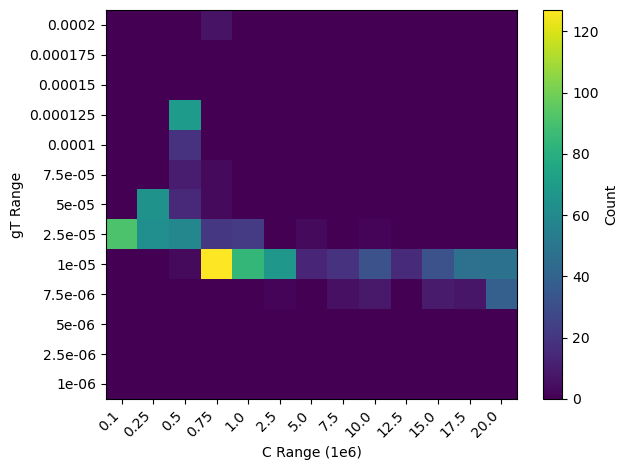

In [13]:
sample_size=1000
min_p1, min_p2, min_coords = calculate_objective_function('term1',sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes

y_edges = np.array( [0.01e-5,0.15e-5,0.3e-5,0.6e-5,0.8e-5,1.1e-5,3e-5,6e-5,8e-5,11e-5,13e-5,16e-5,18e-5,21e-5])
x_edges = np.array( [0.001e6,0.2e6, 0.3e6, 0.6e6, 0.8e6 ,1.1e6 ,3e6, 6e6, 8e6, 11e6, 13e6, 16e6, 18e6, 21e6]) /1e6
counts, _, _ = np.histogram2d(np.array(min_p1)/1e6, min_p2, bins=[x_edges, y_edges])
plt.clf()

fig, ax = plt.subplots()

im = ax.pcolormesh(np.arange(len(x_edges)), np.arange(len(y_edges)), 
                    counts.T, cmap='viridis', shading='auto', vmin=0) #, vmax=1000)

x_labels = np.array([0.1e6, 0.25e6, 0.5e6, 0.75e6 ,1.0e6 ,2.5e6, 5.0e6, 7.5e6, 10.0e6, 12.5e6, 15e6, 17.5e6, 20e6]) /1e6
y_labels = [0.1e-5,0.25e-5,0.5e-5,0.75e-5,1e-5,2.5e-5,5e-5,7.5e-5,10e-5,12.5e-5,15e-5,17.5e-5,20e-5]

# Set tick positions and labels
ax.set_xticks(np.arange(len(x_labels))+0.5)
ax.set_yticks(np.arange(len(y_labels))+0.5)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_yticklabels(y_labels)

ax.set_xlabel("C Range (1e6)")
ax.set_ylabel("gT Range")
plt.colorbar(im, label='Count')
plt.tight_layout()

#plt.savefig(os.path.join(figure_dir,pism_presentday_ensemble+'_Hist2D_Sample'+str(sample_size)+'.png'))    

Sampling, this might take a moment...


<Figure size 640x480 with 0 Axes>

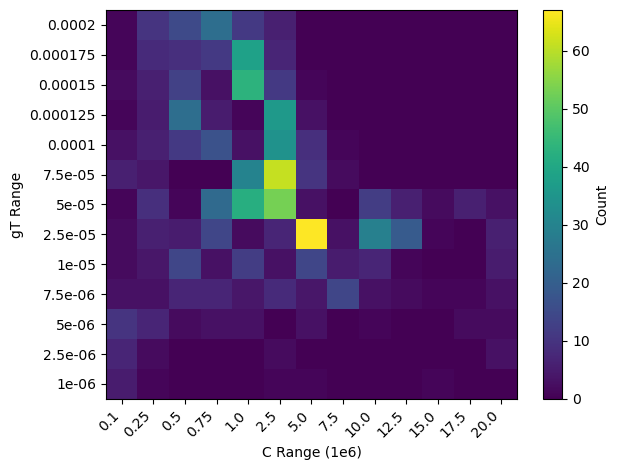

In [14]:
sample_size=1000
min_p1, min_p2, min_coords = calculate_objective_function('term2',sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes

y_edges = np.array( [0.01e-5,0.15e-5,0.3e-5,0.6e-5,0.8e-5,1.1e-5,3e-5,6e-5,8e-5,11e-5,13e-5,16e-5,18e-5,21e-5])
x_edges = np.array( [0.001e6,0.2e6, 0.3e6, 0.6e6, 0.8e6 ,1.1e6 ,3e6, 6e6, 8e6, 11e6, 13e6, 16e6, 18e6, 21e6]) /1e6
counts, _, _ = np.histogram2d(np.array(min_p1)/1e6, min_p2, bins=[x_edges, y_edges])
plt.clf()

fig, ax = plt.subplots()

im = ax.pcolormesh(np.arange(len(x_edges)), np.arange(len(y_edges)), 
                    counts.T, cmap='viridis', shading='auto', vmin=0) #, vmax=1000)

x_labels = np.array([0.1e6, 0.25e6, 0.5e6, 0.75e6 ,1.0e6 ,2.5e6, 5.0e6, 7.5e6, 10.0e6, 12.5e6, 15e6, 17.5e6, 20e6]) /1e6
y_labels = [0.1e-5,0.25e-5,0.5e-5,0.75e-5,1e-5,2.5e-5,5e-5,7.5e-5,10e-5,12.5e-5,15e-5,17.5e-5,20e-5]

# Set tick positions and labels
ax.set_xticks(np.arange(len(x_labels))+0.5)
ax.set_yticks(np.arange(len(y_labels))+0.5)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_yticklabels(y_labels)

ax.set_xlabel("C Range (1e6)")
ax.set_ylabel("gT Range")
plt.colorbar(im, label='Count')
plt.tight_layout()

#plt.savefig(os.path.join(figure_dir,pism_presentday_ensemble+'_Hist2D_Sample'+str(sample_size)+'.png'))    

Sampling, this might take a moment...


<Figure size 640x480 with 0 Axes>

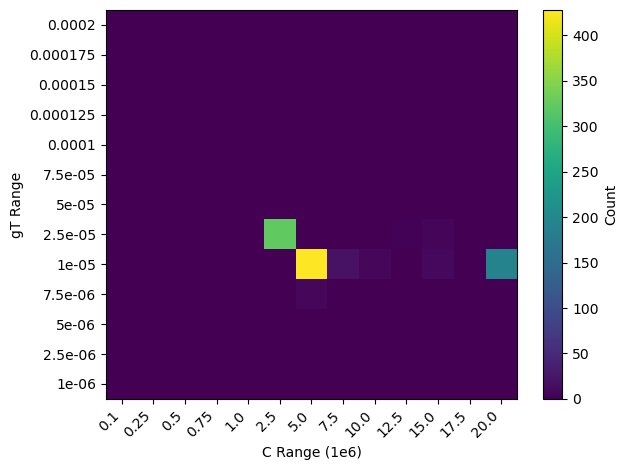

In [15]:
sample_size=1000
min_p1, min_p2, min_coords = calculate_objective_function('term3',sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes

y_edges = np.array( [0.01e-5,0.15e-5,0.3e-5,0.6e-5,0.8e-5,1.1e-5,3e-5,6e-5,8e-5,11e-5,13e-5,16e-5,18e-5,21e-5])
x_edges = np.array( [0.001e6,0.2e6, 0.3e6, 0.6e6, 0.8e6 ,1.1e6 ,3e6, 6e6, 8e6, 11e6, 13e6, 16e6, 18e6, 21e6]) /1e6
counts, _, _ = np.histogram2d(np.array(min_p1)/1e6, min_p2, bins=[x_edges, y_edges])
plt.clf()

fig, ax = plt.subplots()

im = ax.pcolormesh(np.arange(len(x_edges)), np.arange(len(y_edges)), 
                    counts.T, cmap='viridis', shading='auto', vmin=0) #, vmax=1000)

x_labels = np.array([0.1e6, 0.25e6, 0.5e6, 0.75e6 ,1.0e6 ,2.5e6, 5.0e6, 7.5e6, 10.0e6, 12.5e6, 15e6, 17.5e6, 20e6]) /1e6
y_labels = [0.1e-5,0.25e-5,0.5e-5,0.75e-5,1e-5,2.5e-5,5e-5,7.5e-5,10e-5,12.5e-5,15e-5,17.5e-5,20e-5]

# Set tick positions and labels
ax.set_xticks(np.arange(len(x_labels))+0.5)
ax.set_yticks(np.arange(len(y_labels))+0.5)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_yticklabels(y_labels)

ax.set_xlabel("C Range (1e6)")
ax.set_ylabel("gT Range")
plt.colorbar(im, label='Count')
plt.tight_layout()

#plt.savefig(os.path.join(figure_dir,pism_presentday_ensemble+'_Hist2D_Sample'+str(sample_size)+'.png'))    

# Select parameters
It is not straightforward how to select the 5th and 95th percentile parameters from the PICO ensemble, a look into the sensitivity might help

In [17]:
# Median the most frequent value
C= 5e6
gT=1e-5

for basin in range(1,20): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=C,p2=gT,basin=basin).values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=C,p2=gT).values)

Basin  1 : 1.07 m/a/K
Basin  2 : 2.04 m/a/K
Basin  3 : 2.52 m/a/K
Basin  4 : 2.4 m/a/K
Basin  5 : 3.81 m/a/K
Basin  6 : 2.76 m/a/K
Basin  7 : 3.08 m/a/K
Basin  8 : 3.97 m/a/K
Basin  9 : 3.94 m/a/K
Basin  10 : 3.9 m/a/K
Basin  11 : 3.76 m/a/K
Basin  12 : 0.91 m/a/K
Basin  13 : 3.44 m/a/K
Basin  14 : 3.18 m/a/K
Basin  15 : 3.39 m/a/K
Basin  16 : 3.04 m/a/K
Basin  17 : 4.18 m/a/K
Basin  18 : 2.62 m/a/K
Basin  19 : 3.47 m/a/K
Corresponding deltaT values: [-0.52 -0.38 -1.13 -1.67 -1.23 -0.58 -0.45 -0.25 -0.75 -1.   -0.02 -0.58
 -1.27  1.2  -2.   -2.    2.   -0.65 -0.58]


In [18]:
# For the 5th percentile, two values are possible, either small(est) C and corresponding gammaT, or other way around
# Given the different sensitivities in different basins, it might be worth trying both
C= 0.1e6
gT=2.5e-5
for basin in range(1,20): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=C,p2=gT,basin=basin).values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=C,p2=gT).values)

C= 5e6
gT=0.5e-5
for basin in range(1,20): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=C,p2=gT,basin=basin).values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=C,p2=gT).values)

Basin  1 : 0.11 m/a/K
Basin  2 : 0.5 m/a/K
Basin  3 : 0.75 m/a/K
Basin  4 : 0.8 m/a/K
Basin  5 : 4.45 m/a/K
Basin  6 : 0.57 m/a/K
Basin  7 : 1.78 m/a/K
Basin  8 : 5.31 m/a/K
Basin  9 : 5.25 m/a/K
Basin  10 : 4.93 m/a/K
Basin  11 : 4.77 m/a/K
Basin  12 : 0.11 m/a/K
Basin  13 : 2.41 m/a/K
Basin  14 : 5.17 m/a/K
Basin  15 : 2.03 m/a/K
Basin  16 : 1.36 m/a/K
Basin  17 : 9.71 m/a/K
Basin  18 : 0.82 m/a/K
Basin  19 : 3.03 m/a/K
Corresponding deltaT values: [ 2.    0.83  0.3  -0.83 -1.17  1.2   0.35 -0.   -0.63 -0.85  0.08  2.
 -0.05  1.52 -1.4   0.23  0.7   0.4  -0.25]
Basin  1 : 0.77 m/a/K
Basin  2 : 1.29 m/a/K
Basin  3 : 1.51 m/a/K
Basin  4 : 1.46 m/a/K
Basin  5 : 1.99 m/a/K
Basin  6 : 1.61 m/a/K
Basin  7 : 1.73 m/a/K
Basin  8 : 1.78 m/a/K
Basin  9 : 2.03 m/a/K
Basin  10 : 2.02 m/a/K
Basin  11 : 1.96 m/a/K
Basin  12 : 0.69 m/a/K
Basin  13 : 1.87 m/a/K
Basin  14 : 2.03 m/a/K
Basin  15 : 1.81 m/a/K
Basin  16 : 1.71 m/a/K
Basin  17 : 2.09 m/a/K
Basin  18 : 1.56 m/a/K
Basin  19 : 1.87 m/a/K
Co

In [36]:
# For the 95th percentile, two values are possible, either larg(est) C and corresponding gammaT, or other way around
# Given the different sensitivities in different basins, I would suggest trying both. Or focusig on the relevant regions
# or chose the parameters that yield highest sensitivity in the corresponding region
C= 20e6
gT=1e-5
for basin in range(1,20): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=C,p2=gT,basin=basin).values,2), 'm/a/K')
print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=C,p2=gT).values)

# For the 95th percentile, two values are possible, either larg(est) C and corresponding gammaT, or other way around
C= 0.5e6
gT=12.5e-5
for basin in range(1,20): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=C,p2=gT,basin=basin).values,2), 'm/a/K')
print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=C,p2=gT).values)

Basin  1 : 1.97 m/a/K
Basin  2 : 2.78 m/a/K
Basin  3 : 3.18 m/a/K
Basin  4 : 2.99 m/a/K
Basin  5 : 3.97 m/a/K
Basin  6 : 3.38 m/a/K
Basin  7 : 3.55 m/a/K
Basin  8 : 4.08 m/a/K
Basin  9 : 4.07 m/a/K
Basin  10 : 4.04 m/a/K
Basin  11 : 3.96 m/a/K
Basin  12 : 1.68 m/a/K
Basin  13 : 3.79 m/a/K
Basin  14 : 4.09 m/a/K
Basin  15 : 3.78 m/a/K
Basin  16 : 3.59 m/a/K
Basin  17 : 4.19 m/a/K
Basin  18 : 3.27 m/a/K
Basin  19 : 3.79 m/a/K
Corresponding deltaT values: [-0.63 -0.48 -1.25 -1.75 -1.25 -0.67 -0.58 -0.35 -0.77 -1.02 -0.05 -0.7
 -1.45  0.98 -2.   -2.    2.   -0.75 -0.65]
Basin  1 : 0.54 m/a/K
Basin  2 : 1.57 m/a/K
Basin  3 : 2.28 m/a/K
Basin  4 : 2.62 m/a/K
Basin  5 : 17.17 m/a/K
Basin  6 : 2.51 m/a/K
Basin  7 : 6.22 m/a/K
Basin  8 : 20.19 m/a/K
Basin  9 : 20.94 m/a/K
Basin  10 : 20.07 m/a/K
Basin  11 : 18.7 m/a/K
Basin  12 : 0.35 m/a/K
Basin  13 : 7.85 m/a/K
Basin  14 : 18.37 m/a/K
Basin  15 : 8.5 m/a/K
Basin  16 : 3.97 m/a/K
Basin  17 : 45.66 m/a/K
Basin  18 : 2.73 m/a/K
Basin  19 : 11.51